# 전이 학습을 통한 PlantVillage 데이터셋 식물 이미지 분류

여기서 살펴볼 것은 사전학습된 ResNet18 모델을 통해 PlantVillage 데이터셋의 식물 이미지를 분류하는 코드이다.

# 사전 작업

구글 코랩에서 구글 드라이브에 저장된 데이터셋에 접근하고자 한다면 아래 코드를 통해 구글 드라이브를 마운트(mount)시켜야 한다. 그러면 구글 드라이브를 로컬 드라이브처럼 사용할 수 있게 된다.

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

다음 코드는 주피터 노트북 브라우저에서 matplotlib 실행 결과를 볼 수 있도록 하기 위한 것이다.

In [ ]:
%matplotlib inline

# 패키지 및 모듈 불러오기

코드 실행에 필요한 패키지 및 모듈을 불러온다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# PlantVillage 데이터셋 준비

본 튜토리얼에 사용된 원래의 데이터셋은 아래 사이트에서 구할 수 있다.
  <https://download.pytorch.org/tutorial/hymenoptera_data.zip>

여기서는 PlantVillage 데이터셋을 사용했다. 데이터셋을 다운로드한 후, 적당한 위치에 압축을 풀어서 저장해둔다.  



## 이미지 변환 설정

* torchvision.transforms.Compose(...): 여러 변환을 조합할 수 있다.
* torchvision.transforms.RandomResizedCrop(224): 원 이미지의 임의의 영역을 224x224 크기로 잘라내어 새로운 이미지를 만든다.
* torchvision.transforms.RandomHorizontalFlip(): 주어진 확률(디폴트값은 0.5)로 이미지를 좌우로 뒤집는다.
* torchvision.transforms.ToTensor(): 넘파이 이미지를 텐서 이미지로 바꾼다. 축 변환이 필요하다.
* torchvision.transforms.Normalize(mean, std): 픽셀값을 정규화한다.
* torchvision.transforms.Resize(256): 이미지를 주어진 크기로 확대/축소한다.
* torchvision.transforms.CenterCrop(224): 원 이미지의 중앙을 기준으로 224x224 크기의 영역을 잘라내어 새로운 이미지를 만든다.

## Dataset 객체 생성

* torchvision.datasets.ImageFolder(root, transform)
  - root 폴더 아래에 클래스별 폴더가 구성된 경우에 데이터셋 클래스를 반환하는 함수이다.
  - transform은 이미지에 대한 변환을 포함한다. 

* torch.utils.data.Dataset 
  - 데이터셋을 나타내는 추상 클래스를 나타낸다. 
  - 파이토치 데이터셋은 Dataset을 상속하여 다음 메소드를 오버라이드해야 한다.
    + \_\_len\_\_: 데이터셋의 크기를 얻는데 사용된다.
    + \_\_getitem\_\_: i번째 샘플을 찾는데 사용된다.  
  - Dataset 객체는 torch.utils.data.DataLoader의 전달 인자로 사용된다. 

## DataLoader 객체 생성

* torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
  - Dataset 객체로부터 데이터를 읽어들여 DataLoader 객체를 생성한다.
  - DataLoader 객체는 데이터셋과 샘플러를 결합하여 주어진 dataset에 대한 iterable을 제공한다.

* DataLoader는 다음과 같은 역할을 한다.
  - 데이터를 미니 배치 단위로 묶는다.
  - 데이터를 랜덤하게 섞는다.
  - 병렬 처리를 통해 데이터를 로딩한다.


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
              

## 클래스 이름


* ImageFolder() 함수로 Dataset을 생성하면 폴더 이름을 기준으로 클래스 이름이 정해진다. 해당 클래스 이름은 .classes 속성으로 확인할 수 있다.

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)
print(class_names)
print(num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

# 미니 배치 이미지 출력을 위한 헬퍼 함수

* 데이터 로더에서 미니 배치를 하나 꺼내서 출력한다.



##  이미지 미니 배치 하나 불러오기: inputs, classes = next(iter(dataloaders['train']))


* DataLoader
  - 데이터셋을 로딩(loading)하는 클래스이다
  - 데이터셋을 배치(batch)라는 작은 단위로 쪼갠다
  - 학습시 반복문 안에서 데이터를 공급한다

* iter & next
  - iter는 전달 인자로 주어진 반복 가능한(iterable) 객체의 반복자(iterator)를 반환한다
  - next는 호출시마다 전달 인자로 주어진 반복자의 요소를 차례대로 하나씩 꺼내준다

* 반복자(iterator)
  - 요소의 값을 하나씩 차례대로 꺼낼수 있는 기능을 제공하는 객체이다
  - iter 함수에 의해 반환된다
  - 반복자를 next 함수에 전달 인자로 입력하면 반복자의 요소를 하나씩 꺼낼 수 있다 

* 반복 가능한(iterable) 객체
  - 리스트, 딕셔너리, 셋, 튜플, 문자열 등과 같이 iter 함수의 전달 인자로 입력하여 iterator 객체를 얻을 수 있는 객체를 뜻한다

* next(iter(dataloaders['train']))
  - 데이터로더에 대한 반복자를 얻은 후, 요소 하나를 반환한다
  - 해당 요소는 배치 크기를 가진 이미지와 레이블로 이뤄진 리스트이다.  


## 이미지 그리드 만들기: out = torchvision.utils.make_grid(inputs)

* torchvision.utils.make_grid
  - B x C x H x W 모양의 4D 미니 배치 텐서 (또는 동일 크기 이미지 리스트)에 대한 이미지 그리드를 반환하는 함수이다
  - 그리드 한 행에 들어갈 이미지 갯수는 디폴트로 8개이다 (아래 코드에서는 nrow=5를 전달 인자로 입력했기 때문에 이미지 갯수가 5개이다)
  - 반환되는 이미지 그리드는 C x H x W 모양의 텐서이다.

## 헬퍼 함수: imshow(inp, title=None)

* inp.numpy().transpose((1, 2, 0))
  - inp 텐서를 넘파이 배열로 변환하고 축의 순서를 바꾼다 (C x H x W --> H x W x C)

* inp = std * inp + mean
  - 평균과 표준 편차를 바꾼다
  - data transform시 수행한 연산의 역산에 해당한다

* numpy.clip(inp. 0, 1)
  - inp 요소의 값을 0과 1로 제한한다

* plt.imshow(inp)
  - inp 데이터를 이미지 형식으로 출력한다
  - 데이터는 H x W 또는 H x W x C 형식이어야 한다

* plt.title(title)
  - 그래프에 타이틀을 추가한다   

torch.Size([3, 454, 1810])


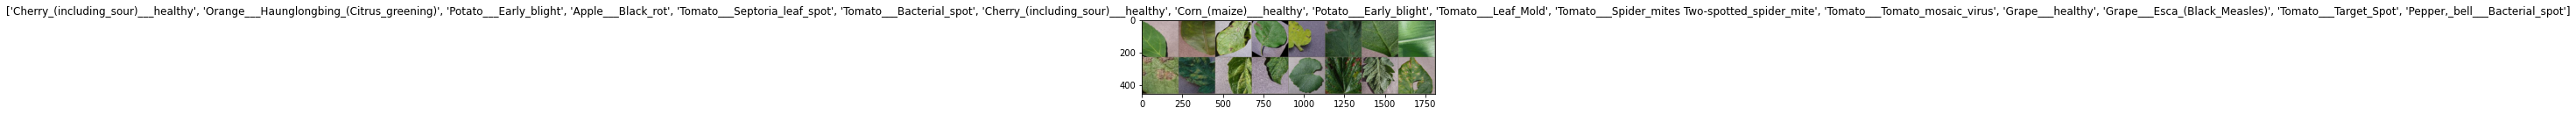

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(1)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)
print(out.shape)

imshow(out, title=[class_names[x] for x in classes])

# 모델 훈련 함수

신경망 모델을 훈련시키는 함수이다.

* with torch.set_grad_enabled(True): 그래디언트 계산을 on/off 시키는 컨텍스트 매니저이다.
* outputs = model(inputs): 모델에 입력을 전달하여 출력을 구한다.
* _, preds = torch.max(outputs, 1)
    - outputs는 batch_size x class_no 차원을 갖는다.
    - 두 번째 전달 함수 1은 두 번째 차원을 기준으로 최댓값을 구하기 위한 것이다.
    - torch.max() 함수의 반환값은 해당 최댓값과 그 최댓값이 위치하는 인덱스로 구성된 튜플이다.
* loss = criterion(outputs, labels): 출력과 레이블을 통해 손실 함수의 값을 구한다.
* loss.backward(): 파라미터에 대한 손실 함수의 미분을 구한다.
* optimizer.step(): 손실 함수 미분값을 이용하여 파라미터 값을 업데이트한다.
* model.load_state_dict(best_model_wts): best_model_wts에 저장된 파라미터 값을 model의 파라미터에 저장한다.


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode --> 드롭아웃, 배치 정규화
            else:
                model.eval()   # Set model to evaluate mode --> 드롭아웃, 배치 정규화

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # batch_size x classes에서 dim=1에 대한 (value,index)를 반환
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# 헬퍼 함수: visualize_model(model, num_images=6)

신경말 모델에 일부 이미지를 입력하여 출력을 구하고 이미지와 함께 출력을 디스플레이하는 함수이다.

* was_training = model.training: 본 함수가 호출된 시점에 model이 training 모드였는지 여부를 저장해둔다.
* model.eval(): 모델을 evaluation 모드로 변경한다. Dropout이나 batch normalization이 비활성화된다.
* with torch.no_grad(): 그래디언트 계산 관련 기능을 비활성화시킨다.
* for i, (inputs, labels) in enumerate(valid_dataloader): 데이터로더의 미니배치를 인덱스와 함께 불러와서 순환문을 실행한다.
* inputs.size()[0]: 입력은 bxcxhxw 형태이므로 이 값은 batch_size에 해당한다.
* matplotlib.pyplot.subplot(nrows, ncols, index): 현재 선택된 figure에 서브플롯을 그리기 위해 축을 추가한다.
* ax.axis('off'): 서브플롯의 축을 삭제한다.
* ax.set_title('predicted: {}'.format(class_names[preds[j]])): 서브플롯에 타이틀을 추가한다. 타이틀 물자열은 신경망이 예측한 클래스 이름이다.
* imshow(inputs.cpu().data[j]): 미니배치의 j번째 이미지를 디스플레이한다.
* model.train(mode=was_training): model이 원래 training 모드였다면 다시 training 모드로 복귀시킨다.





In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# ResNet18 모델 불러오기 & 하이퍼파라미터 설정
  
* ResNet18 모델을 불러온다. 이때, pretrained를 True로 설정하여 기 학습된 파라미터까지 가져온다.

* for문을 통해서 불러온 모델의 파라미터의 requires_grad 속성을 모두 False로 변경한다. 이는 해당 모델 파라미터의 기울기 계산을 방지하여 경사 하강법에 의한 파라미터 값 조정을 막는다.

* 출력층에 해당하는 완전 연결층의 출력 노드의 갯수를 5개로 변경한다. 클래스의 갯수가 5개이기 때문이다.

* Loss 함수는 cross entropy 함수이다.

* Optimizer로는 SGD(stochastic gradient descent)를 선택했다. Optimizer에 전달된 학습 파라미터는 완전 연결층 파라미터이다.



In [ ]:
model_fe = torchvision.models.resnet18(pretrained=True)

for param in model_fe.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_fe.fc.in_features
model_fe.fc = nn.Linear(num_ftrs, num_classes)

model_fe = model_fe.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(model_fe.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# ResNet 모델의 완전 연결층 학습




In [ ]:
model_fe = train_model(model_fe, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0971 Acc: 0.7365
val Loss: 0.4114 Acc: 0.8832

Epoch 1/24
----------
train Loss: 0.6266 Acc: 0.8268
val Loss: 0.3520 Acc: 0.8948

Epoch 2/24
----------
train Loss: 0.5586 Acc: 0.8390
val Loss: 0.3078 Acc: 0.9051

Epoch 3/24
----------
train Loss: 0.5201 Acc: 0.8464
val Loss: 0.2964 Acc: 0.9072

Epoch 4/24
----------
train Loss: 0.4987 Acc: 0.8514
val Loss: 0.2921 Acc: 0.9079

Epoch 5/24
----------
train Loss: 0.4820 Acc: 0.8554
val Loss: 0.2960 Acc: 0.9087

Epoch 6/24
----------
train Loss: 0.4736 Acc: 0.8565
val Loss: 0.2813 Acc: 0.9107

Epoch 7/24
----------
train Loss: 0.4542 Acc: 0.8646
val Loss: 0.2595 Acc: 0.9196

Epoch 8/24
----------
train Loss: 0.4568 Acc: 0.8627
val Loss: 0.2724 Acc: 0.9137

Epoch 9/24
----------
train Loss: 0.4489 Acc: 0.8654
val Loss: 0.2662 Acc: 0.9164

Epoch 10/24
----------
train Loss: 0.4471 Acc: 0.8653
val Loss: 0.2831 Acc: 0.9095

Epoch 11/24
----------
train Loss: 0.4451 Acc: 0.8673
val Loss: 0.2590 Acc: 0.9180

Ep

# 학습된 모델 시험

* 검증 데이터셋 샘플 몇 개를 학습된 신경망에 입력하여 출력을 확인해본다.

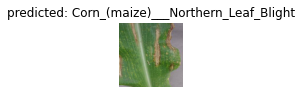

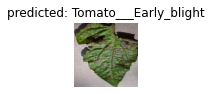

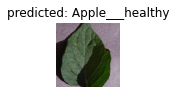

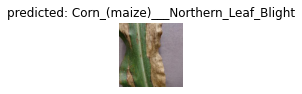

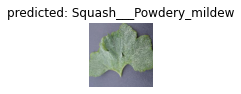

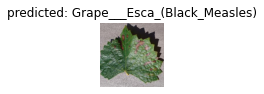

In [ ]:
visualize_model(model_fe,6)

plt.ioff()
plt.show()

# 학습된 모델 파라미터 저장

* 모델의 파라미터를 저장한다.


In [ ]:
# Save the model parameters
torch.save(model_fe.state_dict(), './tf_resnet18_plantvillage.ckpt')

# 학습된 모델 파라미터 불러와서 사용하기

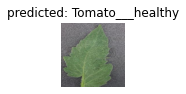

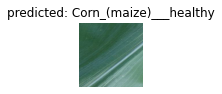

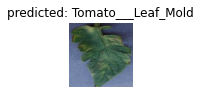

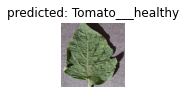

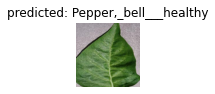

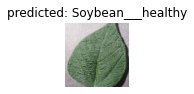

In [ ]:
model = torchvision.models.resnet18(pretrained=False)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model.load_state_dict(torch.load('./tf_resnet18_plantvillage.ckpt'))    

model = model.to(device)

visualize_model(model,6)

plt.show()

# 헬퍼 함수: predict_class(model,img_path)

img_path에서 이미지 파일을 읽어들여서 model에 입력하여 예측값을 구한다. 또한, 해당 이미지를 화면에 디스플레이한다.

* transforms.Compose(): 선택된 이미지를 위한 이미지 변환을 결합시킨다. 검증 모드에서 사용되는 이미지 변환으로 설정한다.
* img = transform(img)[:3,:,:].unsqueeze(0): 채널을 3개(RGB)까지만 선택하고 나머지는 버린다. (알파 채널이 있으면 버린다는 뜻.) unsqueeze(0)는 0차원을 하나 추가한다. batch_size 차원에 해당한다.
* np.transpose(img.to('cpu').squeeze().numpy(),(1,2,0)): img를 CPU로 보내고 배치 차원을 제거한 다음, 텐서를 넘파이 배열로 바꾸고 차원을 hxwxc 순서로 변경한다. imshow() 함수의 전달 인자도 넘겨주기 위해서이다.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Apple___Cedar_apple_rust


2

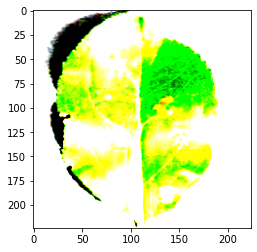

In [ ]:
from PIL import Image
from PIL import ImageFile

def predict_class(model,img_path):
    
    #Preprocessing the input image
    transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                     [0.229, 0.224, 0.225])])
    img = Image.open(img_path)

    # 이미지 파일을 얻을 후에는 아래와 같이 모델에 입력하여 출력을 얻는다.
    img = transform(img)[:3,:,:].unsqueeze(0)
    
    img = img.to(device)
    model.to(device)
    
    model.eval()

    output = model(img)
    _, pred = torch.max(output, 1)

    plt.imshow(np.transpose(img.to('cpu').squeeze().numpy(),(1,2,0)))

    print(class_names[pred.item()])
   
    return pred.item()


predict_class(model,'./dataset/test/AppleCedarRust1.JPG')